In [66]:
using Printf
using Random
using Statistics
using LinearAlgebra

using Flux
using DifferentialEquations
using DiffEqFlux

using JLD2
using BSON
using Plots

using Flux: @epochs

In [67]:
#####
##### Load data from JLD2 file
#####

file = jldopen("../data/ocean_convection_profiles.jld2")

Is = keys(file["timeseries/t"])

Nz = file["grid/Nz"]
Lz = file["grid/Lz"]
Nt = length(Is)

t = zeros(Nt)
T = T_data = zeros(Nt, Nz)
wT = zeros(Nt, Nz)

for (i, I) in enumerate(Is)
    t[i] = file["timeseries/t/$I"]
    T[i, :] = file["timeseries/T/$I"][1, 1, 2:Nz+1]
    wT[i, :] = file["timeseries/wT/$I"][1, 1, 2:Nz+1]
end

In [68]:
#####
##### Plot animation of T(z,t) from data
#####

z = file["grid/zC"]

anim = @animate for n=1:10:Nt
    t_str = @sprintf("%.2f", t[n] / 86400)
    plot(T[n, :], z, linewidth=2,
         xlim=(19, 20), ylim=(-100, 0), label="",
         xlabel="Temperature (C)", ylabel="Depth (z)",
         title="Deepening mixed layer: $t_str days", show=false)
end

gif(anim, "deepening_mixed_layer.gif", fps=15)

┌ Info: Saved animation to 
│   fn = /home/alir/6S898-climate-parameterization/notebooks/deepening_mixed_layer.gif
└ @ Plots /home/alir/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/home/alir/6S898-climate-parameterization/notebooks/deepening_mixed_layer.gif")

In [69]:
#####
##### Coarse grain data to 32 vertical levels (plus halo regions)
#####

function coarse_grain(data, resolution)
    @assert length(data) % resolution == 0
    s = length(data) / resolution
    
    data_cs = zeros(resolution)
    for i in 1:resolution
        t = data[Int((i-1)*s+1):Int(i*s)]
        data_cs[i] = mean(t)
    end
    
    return data_cs
end

coarse_grain (generic function with 1 method)

In [71]:
coarse_resolution = cr = 32

T_cs = zeros(coarse_resolution+2, Nt)
wT_cs = zeros(coarse_resolution+2, Nt)

z_cs = coarse_grain(collect(z), cr)

for n=1:Nt
    T_cs[2:end-1, n] .= coarse_grain(T[n, :], coarse_resolution)
    wT_cs[2:end-1, n] .= coarse_grain(wT[n, :], coarse_resolution)
end

# Fill halo regions to enforce boundary conditions.
T_cs[1,   :] .= T_cs[2,     :]
T_cs[end, :] .= T_cs[end-1, :]

wT_cs[1,   :] .= wT_cs[2,     :]
wT_cs[end, :] .= wT_cs[end-1, :];

In [6]:
#####
##### Plot coarse temperature and wT profiles
#####

@info "Plotting coarse temperature profile..."

anim = @animate for n=1:10:Nt
    t_str = @sprintf("%.2f", t[n] / 86400)
    plot(T_cs[2:cr+1, n], z_cs, linewidth=2,
         xlim=(19, 20), ylim=(-100, 0), label="",
         xlabel="Temperature (C)", ylabel="Depth (z)",
         title="Deepening mixed layer: $t_str days", show=false)
end

gif_T = gif(anim, "deepening_mixed_layer_T_coarse.gif", fps=15)

display(gif_T)

@info "Plotting coarse wT profile..."

anim = @animate for n=1:10:Nt
    t_str = @sprintf("%.2f", t[n] / 86400)
    plot(wT_cs[2:cr+1, n], z_cs, linewidth=2,
         xlim=(-1e-4, 1e-4), ylim=(-100, 0), label="",
         xlabel="Temperature (C)", ylabel="Depth (z)",
         title="Deepening mixed layer: $t_str days", show=false)
end

gif_wT = gif(anim, "deepening_mixed_layer_wT_coarse.gif", fps=15)

display(gif_wT)

┌ Info: Plotting coarse temperature profile...
└ @ Main In[6]:5


Plots.AnimatedGif("/home/alir/6S898-climate-parameterization/notebooks/deepening_mixed_layer_T_coarse.gif")

┌ Info: Saved animation to 
│   fn = /home/alir/6S898-climate-parameterization/notebooks/deepening_mixed_layer_T_coarse.gif
└ @ Plots /home/alir/.julia/packages/Plots/Iuc9S/src/animation.jl:95
┌ Info: Plotting coarse wT profile...
└ @ Main In[6]:19


Plots.AnimatedGif("/home/alir/6S898-climate-parameterization/notebooks/deepening_mixed_layer_wT_coarse.gif")

┌ Info: Saved animation to 
│   fn = /home/alir/6S898-climate-parameterization/notebooks/deepening_mixed_layer_wT_coarse.gif
└ @ Plots /home/alir/.julia/packages/Plots/Iuc9S/src/animation.jl:95


In [72]:
#####
##### Generate differentiation matrices
#####

cr_Δz = Lz / cr  # Coarse resolution Δz

# Dzᶠ computes the derivative from cell center to cell (F)aces
Dzᶠ = 1/cr_Δz * Tridiagonal(-ones(cr+1), ones(cr+2), zeros(cr+1))

# Dzᶜ computes the derivative from cell faces to cell (C)enters
Dzᶜ = 1/cr_Δz * Tridiagonal(zeros(cr+1), -ones(cr+2), ones(cr+1))

34×34 Tridiagonal{Float64,Array{Float64,1}}:
 -0.32   0.32    ⋅      ⋅      ⋅    …    ⋅      ⋅      ⋅      ⋅      ⋅  
  0.0   -0.32   0.32    ⋅      ⋅         ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅     0.0   -0.32   0.32    ⋅         ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅     0.0   -0.32   0.32       ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅     0.0   -0.32       ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅      ⋅     0.0   …    ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅      ⋅      ⋅    …    ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅      ⋅  
   ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅      ⋅  
  ⋮   

In [73]:
#####
##### Create training and pre-training data
#####

Tₙ    = zeros(cr+2, Nt-1)
Tₙ₊₁  = zeros(cr+2, Nt-1)
wTₙ   = zeros(cr+2, Nt-1)
∂zTₙ  = zeros(cr+2, Nt-1)
∂zwTₙ = zeros(cr+2, Nt-1)

for i in 1:Nt-1
       Tₙ[:, i] .=  T_cs[:,   i]
     Tₙ₊₁[:, i] .=  T_cs[:, i+1]
      wTₙ[:, i] .= wT_cs[:,   i]
     ∂zTₙ[:, i] .= Dzᶠ * T_cs[:, i]
    ∂zwTₙ[:, i] .= Dzᶜ * wT_cs[:, i]
end

N = 32  # Number of training data pairs.

N_skip = 100  # Skip first N_skip iterations to avoid learning transients.
Ns = N_skip:N+N_skip

pre_training_data = [(Tₙ[:, i], -wTₙ[:, i]) for i in Ns]
training_data = [(Tₙ[:, i], Tₙ₊₁[:, i]) for i in Ns]

rinds = randperm(Nt)[1:N]


In [74]:
#####
##### Create heat flux vector
#####

heat_flux = zeros(cr+2)

Q  = -100
ρ₀ = file["parameters/density"]
cₚ = file["parameters/specific_heat_capacity"]

heat_flux[cr+1] = Q / (ρ₀ * cₚ * cr_Δz)

-7.789678675754626e-6

In [128]:
#####
##### Create neural network
#####

# Complete black box right-hand-side.
# dTdt_NN = Chain(Dense(cr+2,  2cr, tanh),
#                 Dense(2cr,  cr+2))

# Use NN to parameterize the horizontally averaged buoyancy flux (wT).
wT_NN = Chain(T -> Dzᶠ*T,
                Dense(cr+2, 4cr, relu),
                Dense(4cr,  4cr, relu),
                Dense(4cr,  cr+2))

wT_NN_params = Flux.params(wT_NN);

In [136]:
#####
##### Pre-train the neural network on (T, wT) data pairs
#####

pre_loss_function(Tₙ, wTₙ) = sum(abs2, wT_NN(Tₙ) .- wTₙ) ./ sum(abs2, wTₙ)

popt = ADAM(0.01)

function precb()
    loss = sum([pre_loss_function(pre_training_data[i]...) for i in 1:N])
    println("loss = $loss")
    return loss
end

precb()

loss = 1552.3549396700103 (tracked)


1552.3549396700103 (tracked)

In [140]:
popt.eta = 0.001

pre_train_epochs = 20
for _ in 1:pre_train_epochs
    Flux.train!(pre_loss_function, wT_NN_params, pre_training_data, popt, cb = Flux.throttle(precb, 5))
end

loss = 0.9473493092543508 (tracked)
loss = 0.3026277502866552 (tracked)
loss = 0.23137071032673073 (tracked)
loss = 0.24223222236226902 (tracked)
loss = 0.24613675949692151 (tracked)
loss = 0.25042438355140473 (tracked)
loss = 0.2545218931047366 (tracked)
loss = 0.25830863535334553 (tracked)
loss = 0.2617319607206116 (tracked)
loss = 0.2648006531215796 (tracked)
loss = 0.26754198026346204 (tracked)
loss = 0.2699972946605971 (tracked)
loss = 0.27221169361072334 (tracked)
loss = 0.2742297267483547 (tracked)
loss = 0.2760958209758809 (tracked)
loss = 0.2778615626295451 (tracked)
loss = 0.2795960184253897 (tracked)
loss = 0.2813994370056341 (tracked)
loss = 0.2834176938845093 (tracked)
loss = 0.28585356578766596 (tracked)


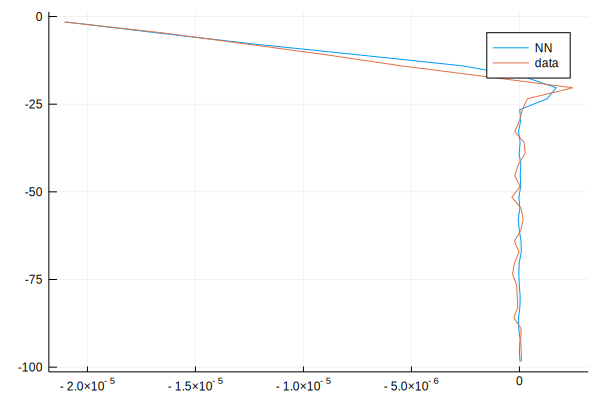

In [141]:
#####
##### Compare wT_NN output with wT data
#####

z_cs = coarse_grain(z, cr)

n = 16

wT = wT_NN(pre_training_data[n][1]) |> Flux.data

plot(wT[2:cr+1], z_cs, label="NN")
plot!(pre_training_data[n][2][2:cr+1], z_cs, label="data")

In [142]:
#####
##### Define neural network for dTdt RHS in terms of wT_NN
#####

wT_NN_copy = deepcopy(wT_NN)

dTdt_NN = Chain(wT_NN_copy,
                x -> Dzᶜ * x .+ heat_flux)

dTdt_NN_params = Flux.params(dTdt_NN);

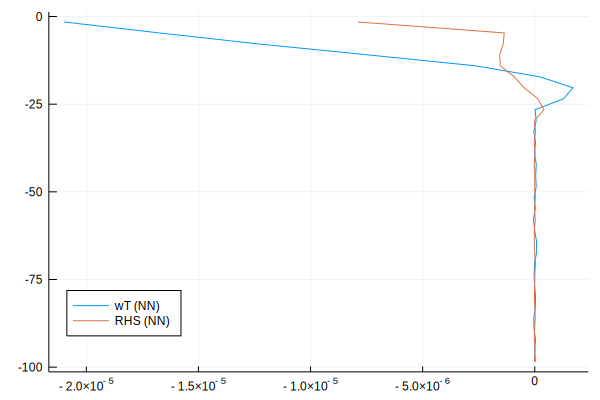

In [143]:
#####
##### Compare output of wT_NN and dTdt_NN
#####

wT = wT_NN(Tₙ[:, 150]) |> Flux.data
RHS = dTdt_NN(Tₙ[:, 150]) |> Flux.data

plot(wT[2:cr+1], z_cs, label="wT (NN)", legend=:bottomleft)
plot!(RHS[2:cr+1], z_cs, label="RHS (NN)")

In [144]:
#####
##### Define loss function for neural ODE
#####

tspan = (0.0, 600.0)  # 10 minutes
neural_pde_prediction(T₀) = neural_ode(dTdt_NN, T₀, tspan, Tsit5(), reltol=1e-4, save_start=false, saveat=tspan[2])

loss_function(Tₙ, Tₙ₊₁) = sum(abs2, Tₙ₊₁ .- neural_pde_prediction(Tₙ))

loss_function (generic function with 1 method)

In [145]:
#####
##### Choose optimization algorithm
#####

opt = ADAM(0.1)

ADAM(0.1, (0.9, 0.999), IdDict{Any,Any}())

In [147]:
#####
##### Callback function to observe training.
#####

N_test = 32

function cb()
    train_loss = sum([loss_function(Tₙ[:, i], Tₙ₊₁[:, i]) for i in Ns])

    nn_pred = neural_ode(dTdt_NN, Tₙ[:, 1], (t[1], t[N_test]), Tsit5(), saveat=t[1:N_test], reltol=1e-4) |> Flux.data
    test_loss = sum(abs2, T_cs[:, 1:N_test] .- nn_pred)
    
    println("train_loss = $train_loss, test_loss = $test_loss")
    return train_loss
end

cb()

train_loss = 0.001317229068283163 (tracked), test_loss = 0.5919061607977687


0.001317229068283163 (tracked)

In [148]:
#####
##### Train!
#####

epochs = 5
best_loss = Inf
last_improvement = 0

for epoch_idx in 1:epochs
    global best_loss, last_improvement

    @info "Epoch $epoch_idx"
    Flux.train!(loss_function, dTdt_NN_params, training_data, opt, cb=cb) # cb=Flux.throttle(cb, 10))
    
    loss = cb()

    if loss <= best_loss
        @info("Record low loss! Saving neural network out to dTdt_NN.bson")
        BSON.@save "dTdt_NN.bson" dTdt_NN
        best_loss = loss
        last_improvement = epoch_idx
    end
   
    # If we haven't seen improvement in 2 epochs, drop our learning rate:
    if epoch_idx - last_improvement >= 2 && opt.eta > 1e-6
        opt.eta /= 2.0
        @warn("Haven't improved in a while, dropping learning rate to $(opt.eta)")

        # After dropping learning rate, give it a few epochs to improve
        last_improvement = epoch_idx
    end
end

┌ Info: Epoch 1
└ @ Main In[148]:12
┌ Warning: Instability detected. Aborting
└ @ DiffEqBase /home/alir/.julia/packages/DiffEqBase/E16PL/src/integrator_interface.jl:176


DimensionMismatch: DimensionMismatch("arrays could not be broadcast to a common size; got a dimension with lengths 32 and 4")

In [106]:
#####
##### Run the neural PDE forward to see how well it performs just by itself.
#####

nn_pred = neural_ode(dTdt_NN, Tₙ[:, 1], (t[1], t[N_test]), Tsit5(), saveat=t[1:N_test], reltol=1e-4) |> Flux.data

anim = @animate for n=1:N_test
    t_str = @sprintf("%.2f", t[n] / 86400)
    plot(T_cs[2:end-1, n], z_cs, linewidth=2,
         xlim=(19, 20), ylim=(-100, 0), label="Data",
         xlabel="Temperature (C)", ylabel="Depth (z)",
         title="Deepening mixed layer: $t_str days",
         legend=:bottomright, show=false)
    plot!(nn_pred[2:end-1, n], z_cs, linewidth=2, label="Neural PDE", show=false)
end

gif(anim, "deepening_mixed_layer_neural_PDE.gif", fps=15)

┌ Info: Saved animation to 
│   fn = /home/alir/6S898-climate-parameterization/notebooks/deepening_mixed_layer_neural_PDE.gif
└ @ Plots /home/alir/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Plots.AnimatedGif("/home/alir/6S898-climate-parameterization/notebooks/deepening_mixed_layer_neural_PDE.gif")